# Introduction

The following notebook is work-in-progress for the CORD-19-research-challenge on Kaggle.

## Dataset

(1) Metadata for papers from these sources are combined: CZI, PMC, BioRxiv/MedRxiv. (total records 29500)  
	- CZI 1236 records  
	- PMC 27337  
	- bioRxiv 566  
	- medRxiv 361  
    
(2) 17K of the paper records have PDFs and the hash of the PDFs are in 'sha'

(3) For PMC sourced papers, one paper's metadata can be associated with one or more PDFs/shas under that paper - a PDF/sha correponding to the main article, and possibly additional PDF/shas corresponding to supporting materials for the article.

(4)	13K of the PDFs were processed with fulltext ('has_full_text'=True)

(5) Various 'keys' are populated with the metadata:  
	- 'pmcid': populated for all PMC paper records (27337 non null)  
	- 'doi': populated for all BioRxiv/MedRxiv paper records and most of the other records (26357 non null)  
	- 'WHO #Covidence': populated for all CZI records and none of the other records (1236 non null)  
	- 'pubmed_id': populated for some of the records  
	- 'Microsoft Academic Paper ID': populated for some of the records  

# Import packages

In [0]:
!pip install -U sentence-transformers
import pandas as pd
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import json
import os
import glob
import re
import warnings
import random

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import word_tokenize

from wordcloud import WordCloud

from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer
import transformers

Requirement already up-to-date: sentence-transformers in /usr/local/lib/python3.6/dist-packages (0.2.5.1)


/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [0]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

/usr/lib/python3.6/threading.py:868: ResourceWarning: unclosed file <_io.FileIO name=66 mode='wb' closefd=True>
  del self._target, self._args, self._kwargs
/usr/lib/python3.6/threading.py:868: ResourceWarning: unclosed file <_io.FileIO name=67 mode='rb' closefd=True>
  del self._target, self._args, self._kwargs


Mounted at /content/drive


In [0]:
os.chdir('/content/drive/My Drive/CORD-19-research-challenge/')
os.listdir()

['COVID.DATA.LIC.AGMT.pdf',
 'json_schema.txt',
 'metadata.csv',
 'metadata.readme',
 'COVID19 (1).ipynb',
 'corona_challenge.ipynb',
 'environment.yml',
 '.ipynb_checkpoints',
 'data']

# Download the stopwords and special characters

In [0]:
nltk.download('stopwords')
stopwords.words('english')
nltk.download('punkt')
warnings.filterwarnings(action='once')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/usr/local/lib/python3.6/dist-packages/nltk/corpus/reader/wordlist.py:28: ResourceWarning: unclosed file <_io.BufferedReader name='/root/nltk_data/corpora/stopwords/english'>
  return concat([self.open(f).read() for f in fileids])


# Process the data

In [0]:
metadata_df = pd.read_csv('./metadata.csv', index_col='sha')
filepath_biorxiv = './biorxiv_medrxiv/biorxiv_medrxiv/'
filepath_noncomm = './noncomm_use_subset/noncomm_use_subset'
filepath_comm = './data/comm_use_subset/comm_use_subset'
filepath_custom = './custom_license/custom_license'

In [0]:
# Load all the json paths
#json_files_biorxiv = get_all_json(filepath_biorxiv)
#json_files_noncomm =  get_all_json(filepath_noncomm)
json_files_comm = get_all_json(filepath_comm)
#json_files_custom = get_all_json(filepath_custom)

# Create data frames for all the abstracts from the datasets
#df_biorxiv = create_df(filepath_biorxiv, " ")
#df_noncomm = create_df(json_files_noncomm, filepath_noncomm)
df_comm = create_df(json_files_comm, filepath_comm)
#df_custom = create_df(json_files_custom, filepath_custom)
#df_meta = df['abstract']

In [0]:
# index all available papers
papers = glob.glob(f'data/**/*.json', recursive=True)
#papers = get_all_json(filepath_comm)

def concat_json_properties(json_list_element, property_name):
    concatenated_content = []
    for item in json_list_element:
        concatenated_content.append(item[property_name])
    return concatenated_content

def get_section_text(body_text, section_name_pattern):
    for section in body_text:
        section_name = section['section']
        if section_name_pattern in section_name.lower():
            return section['text']
        else:
            return 'none'

paper_dict = {}
# loop through the files and create a dictionary indexed by 'paper_id'
number_of_papers = len(papers)
# NOTE: only use some random papers for testing
for idx, paper in enumerate(random.choices(papers, k=1000)):    
    # for each file open it and read as json
    with open(os.path.join(paper)) as json_file:
        paper_json = json.load(json_file)
        paper_id = paper_json['paper_id']
        
        # read title, abstract and body_text
        title = paper_json['metadata']['title']
        abstract_text = concat_json_properties(paper_json['abstract'], 'text')
        #conclusion_text = get_section_text(paper_json['body_text'], 'conclusion')
        conclusion_text = ''
        introduction_text = get_section_text(paper_json['body_text'], 'introduction')
        body_text = concat_json_properties(paper_json['body_text'], 'text')
        
        # extract metadata
        try:
            meta_data = metadata_df.loc[paper_id]
            journal = meta_data['journal']
            publish_date = meta_data['publish_time']
        except:
            journal = ''
            publish_date = ''
        
        # create dict
        paper_dict[paper_json['paper_id']] = {
            'title': title,
            'abstract': abstract_text,
            'body_text': body_text,
            'publish_date': publish_date,
            'journal': journal,
            'conclusion': conclusion_text,
            'introduction': introduction_text
        }


In [0]:
#print(df_noncomm.head())
#print(df_biorxiv.head())
print(df_comm.head())
#print(df_custom.head())
#print(df_meta.head())

                                                text
0  Currently, live-attenuated IBV vaccines are us...
1  Background: Porcine epidemic diarrhea virus (P...
2  The new world arenavirus Junín virus (JUNV) is...
3  A new algorithm for assessing similarity betwe...
4  Avian leukosis virus subgroup J (ALV-J) infect...


In [0]:
df['abstract'].head()

In [0]:
# Drop NA values from data frame
df = df.dropna()

In [0]:
# Filter the data frames and format them for word2vec corpuses and visualizations with wordcloud
#filtered_biorxiv, filtered_biorxiv_visualization = filter_df(df_biorxiv)
#print(filtered_biorxiv)
#filtered_noncomm, filtered_noncomm_visualization = filter_df(df_noncomm)
filtered_comm, filtered_comm_visualization = filter_df(df_comm)
#filtered_custom, filtered_custom_visualization = filter_df(df_custom)

#filtered_meta, filtered_meta_visualization = filter_df(df)

/usr/local/lib/python3.6/dist-packages/nltk/corpus/reader/wordlist.py:28: ResourceWarning: unclosed file <_io.BufferedReader name='/root/nltk_data/corpora/stopwords/english'>
  return concat([self.open(f).read() for f in fileids])


## Helper functions

In [0]:
def get_all_json(filepath):
    return [pos_json for pos_json in os.listdir(filepath) if pos_json.endswith('.json')]

def create_df(file_list, filepath):
    contents = pd.DataFrame(columns=['text'])
    json_pattern = os.path.join(filepath, '*.json')
    file_list = glob.glob(json_pattern)
    for file in file_list:
        with open(file) as json_file:
            data = json_file.read()
        
        obj = json.loads(data)
        if len(obj['abstract']) > 0:
            content = obj['abstract'][0]['text']
            contents = contents.append({'text': content}, ignore_index=True)
    return contents

def filter_df(df):
    filtered_list_visualization = []
    filtered_list = []
    for i in range(len(df)):
        filtered_list.append(simple_preprocess(df.text.values[i]))
        for w in simple_preprocess(df.text.values[i]):
            if w in stopwords.words('english') or len(w) < 2 or w.isnumeric():
                continue
        filtered_list_visualization.append(w)
    return filtered_list, filtered_list_visualization

def visualize_word_frequencies(feature):
    wordcloud = WordCloud()
    frequency_dist = nltk.FreqDist(feature)
    sorted(frequency_dist,key=frequency_dist.__getitem__, reverse=True)[0:50] 
    wordcloud.generate_from_frequencies(frequency_dist)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

In [0]:
def get_dict_element_by_key(element_key):
    text = []
    for key in paper_dict:
        string = paper_dict[key][element_key]
        if (string != 'nan' and string != ''):
            text.append(string)
    return text

# Dataset analysis

(1) Metadata for papers from these sources are combined: CZI, PMC, BioRxiv/MedRxiv. (total records 29500)  
	- CZI 1236 records  
	- PMC 27337  
	- bioRxiv 566  
	- medRxiv 361  
    
(2) 17K of the paper records have PDFs and the hash of the PDFs are in 'sha'

(3) For PMC sourced papers, one paper's metadata can be associated with one or more PDFs/shas under that paper - a PDF/sha correponding to the main article, and possibly additional PDF/shas corresponding to supporting materials for the article.

(4)	13K of the PDFs were processed with fulltext ('has_full_text'=True)

(5) Various 'keys' are populated with the metadata:  
	- 'pmcid': populated for all PMC paper records (27337 non null)  
	- 'doi': populated for all BioRxiv/MedRxiv paper records and most of the other records (26357 non null)  
	- 'WHO #Covidence': populated for all CZI records and none of the other records (1236 non null)  
	- 'pubmed_id': populated for some of the records  
	- 'Microsoft Academic Paper ID': populated for some of the records



## Publications of papers

The dataset contains research papers that have been published in various journals

In [0]:
journal_names = get_dict_element_by_key('journal')
        
values, counts = np.unique(journal_names, return_counts=True)
print(values)
print(counts)

['250 Examens de Laboratoire'
 'Arzneimittel in Schwangerschaft und Stillzeit' 'Cells' 'Crit Care'
 'Current Opinion in Genetics & Development' 'Int J Mol Sci'
 'Intensive Care Med Exp' 'Journal of Neuroimmunology'
 "Jubb, Kennedy & Palmer's Pathology of Domestic Animals: Volume 1"
 'Krankenhaus- und Praxishygiene' "MacSween's Pathology of the Liver"
 'Nonhuman Primates in Biomedical Research' 'Nucleic Acids Res'
 'Ostéopathie pédiatrique' 'PLoS One' 'Pathology of the Lungs' 'Peptides'
 'Pharmacology & Therapeutics' 'Studies in Natural Products Chemistry'
 'World Allergy Organ J' 'nan']
[  1   1   1   3   1   1   1   1   1   1   1   1   1   1   1   1   1   1
   1   1 191]


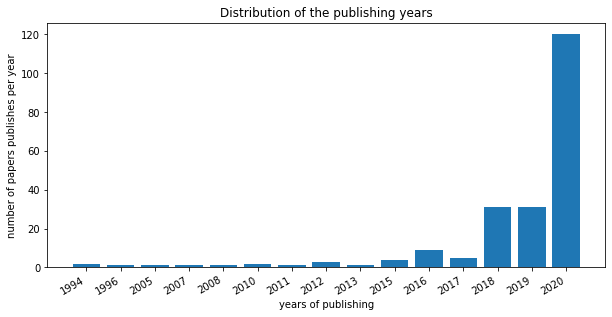

In [0]:
publish_years = []
for key in paper_dict:
    string_date = str(paper_dict[key]['publish_date'])
    if (string_date != 'nan' and string_date != ''):
        match = re.search('[0-9]{4}', string_date)
        
        if match:
            publish_year = match.group(0)
            publish_years.append(publish_year)
        else:
            print(string_date)
            
get_dict_element_by_key('journal')
# plot the distribution of the publishing years
x, y = np.unique(publish_years, return_counts=True)
fig = plt.figure(figsize=(10,5))
plot = fig.add_subplot()
plot.bar(x,y)
plt.gcf().autofmt_xdate()
plt.title("Distribution of the publishing years")
plt.xlabel("years of publishing")
plt.ylabel("number of papers publishes per year")

#mplcursors.cursor(hover=True)

plt.show()

## Topics

The dataset is not limited to papers specifically about COVID-19 but also covers topis about multiple other viruses. 

Speed and strength of an epidemic intervention
Hypokalemia and Clinical Implications in Patients with Coronavirus Disease 2019 (COVID-19)
Population movement, city closure and spatial transmission of the 2019-nCoV 1 infection in China 2
Using heterogeneity in the population structure of U.S. swine farms to compare transmission models for porcine epidemic diarrhoea
Comparative analysis reveals adaptive evolution of bat IFITMs and a novel 1 antiviral determinant
Title: The incubation period of 2019-nCoV infections among travellers from Wuhan, China
50-valent inactivated rhinovirus vaccine is broadly immunogenic in rhesus macaques
ΦX174 Attenuation by Whole Genome Codon Deoptimization
P001 Sepsis impairs the capillary response within hypoxic capillaries and decreases erythrocyte oxygen-dependent ATP efflux P002 Lower serum immunoglobulin G2 level does not predispose to severe flu
Title: The incubation period of 2019-nCoV infections among travellers from Wuhan, China
Long noncoding RNA AVA

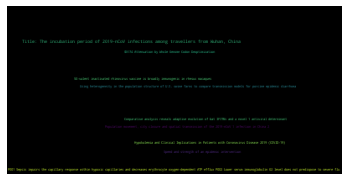

In [0]:
titles = get_dict_element_by_key('title')
        
titles = random.choices(titles, k=20)
print('\n'.join(titles))
visualize_word_frequencies(titles)

In [0]:
titles = np.array(get_dict_element_by_key('title'))

tfidf_vectorizer = TfidfVectorizer()
tfidf = tfidf_vectorizer.fit_transform(titles)

# TODO: create clustering of title sbased on cosine similarity and visualize them (-> see https://www.kaggle.com/maksimeren/covid-19-literature-clustering#Interactive-t-SNE

## Visualize the word frequencies

In [0]:
visualize_word_frequencies(filtered_meta_visualization)

NameError: ignored

In [0]:
visualize_word_frequencies(filtered_noncomm_visualization)

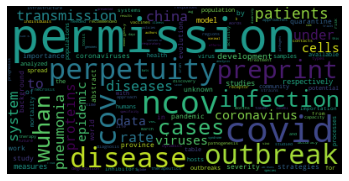

In [0]:
visualize_word_frequencies(filtered_biorxiv_visualization)

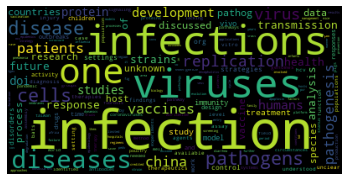

In [0]:
visualize_word_frequencies(filtered_comm_visualization)

In [0]:
visualize_word_frequencies(filtered_custom_visualization)

# Build word2vec models for the data sets

In [0]:

# build vocabulary and train model for the non_comm data set
noncomm_model = Word2Vec(
    filtered_noncomm,
    size=150,
    window=10,
    min_count=2,
    workers=10,
    iter=10)

In [0]:
# build vocabulary and train model for the biorxiv data set
biorxiv_model = Word2Vec(
    filtered_biorxiv,
    size=150,
    window=10,
    min_count=2,
    workers=10,
    iter=10)


In [0]:
# build vocabulary and train model for the comm data set
comm_model = Word2Vec(
    filtered_comm,
    size=150,
    window=10,
    min_count=2,
    workers=10,
    iter=10)

In [0]:
# build vocabulary and train model for the custom data set
custom_model = Word2Vec(
    filtered_custom,
    size=150,
    window=10,
    min_count=2,
    workers=10,
    iter=10)

Explore som similarities of words in the data s

In [0]:
biorxiv_model.wv.most_similar('immunity')

[('length', 0.9989305734634399),
 ('mutagenesis', 0.9988316893577576),
 ('mutant', 0.9987284541130066),
 ('regulating', 0.9986594319343567),
 ('types', 0.9986391067504883),
 ('candidate', 0.9985589385032654),
 ('diversity', 0.9985484480857849),
 ('decay', 0.9985479116439819),
 ('forms', 0.9984673857688904),
 ('glycans', 0.9984411597251892)]

In [0]:
noncomm_model.wv.most_similar('covid')

In [0]:
comm_model.wv.most_similar('covid')

In [0]:
custom_model.wv.most_similar('immunity')

In [0]:
custom_model.wv['covid']

In [0]:
keys = ['covid', 'corona', 'immunity', 'disease', 'distancing', 'wuhan', 'china', 'herd', 'contagious',
        'vaccine', 'transmission', 'food', 'survival', 'deadly', 'cure', 'infectious', 'death']

embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in biorxiv_model.wv.most_similar(word, topn=30):
        words.append(similar_word)
        embeddings.append(biorxiv_model[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

<ipython-input-72-fda6d4d89d6d>:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embeddings.append(biorxiv_model[similar_word])


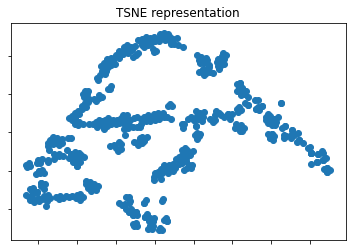

In [0]:
from sklearn.manifold import TSNE
import numpy as np

embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

#Plot the t-SNE output
fig, ax = plt.subplots()
ax.plot(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))[:,0], tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))[:,1], 'o')
ax.set_title('TSNE representation')
ax.set_yticklabels([]) #Hide ticks
ax.set_xticklabels([]) #Hide ticks
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

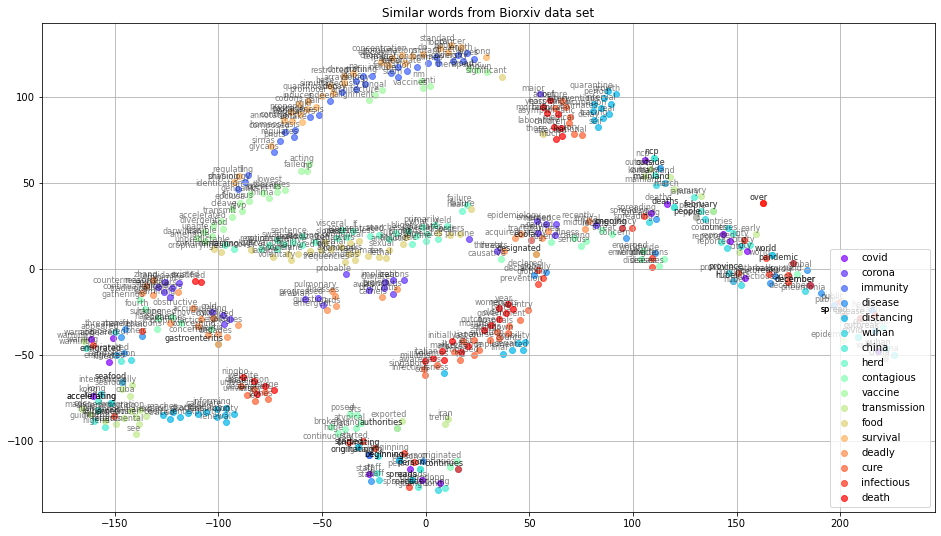

In [0]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm



def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()


tsne_plot_similar_words('Similar words from Biorxiv data set', keys, embeddings_en_2d, word_clusters, 0.7,
                        'similar_words.png')

# Implement a BERT search engine 

Cred to Julien Heiduk (https://www.kaggle.com/zoupet/covid-19-search-engine-with-bert) for the initial idea of using a BERT search engine, which I plan to extend. 

In [0]:
model = SentenceTransformer('bert-base-nli-mean-tokens')

In [0]:
question_embedding = model.encode(['What is known about transmission, incubation, and environmental stability?'])

queries = [       "Is the virus transmitted by aerisol, droplets, food, close contact, fecal matter, or water?",
                  "How long is the incubation period for the virus?",
                  "Can the virus be transmitted asymptomatically or during the incubation period?",
                  "How does weather, heat, and humidity affect the tramsmission of 2019-nCoV?",
                  "How long can the 2019-nCoV virus remain viable on common surfaces?"
              ]
query_embeddings = model.encode(queries)

In [0]:
abstract_embeddings = model.encode(df_comm.text.values)

Currently, live-attenuated IBV vaccines are used to control the disease. However, safety, attenuation and immunization outcomes of current vaccines are not guaranteed. Several studies indicate that attenuated IBV vaccine strains contribute to the emergence of variant viruses in the field due to mutations and recombination. Therefore, there is a need to develop a stable and safe IBV vaccine that will not create variant viruses. In this study, we generated recombinant Newcastle disease viruses (rNDVs) expressing the S1, S2 and S proteins of IBV using reverse genetics technology. Our results showed that the rNDV expressing the S protein of IBV provided better protection than the rNDV expressing S1 or S2 protein of IBV, indicating that the S protein is the best protective antigen of IBV. Immunization of 4-week-old SPF chickens with the rNDV expressing S protein elicited IBV-specific neutralizing antibodies and provided complete protection against virulent IBV and virulent NDV challenges. T

In [0]:
# Find the closest 5 sentences of the corpus for each query sentence based on cosine similarity

closest_n = 5
for query, query_embedding in zip(queries, query_embeddings):
    distances = sc.spatial.distance.cdist([query_embedding], abstract_embeddings, "cosine")[0]

    results = zip(range(len(distances)), distances)
    results = sorted(results, key=lambda x: x[1])

    print("\n\n======================\n\n")
    print("Query:", query)
    print("\nTop 5 most similar sentences in corpus:")

    for idx, distance in results[0:closest_n]:
        print(df_comm['text'][idx].strip(), "\n(Score: %.4f)" % (1-distance),"\n")





Query: Is the virus transmitted by aerisol, droplets, food, close contact, fecal matter, or water?

Top 5 most similar sentences in corpus:
Porcine Epidemic Diarrhea Virus (PEDV), Porcine Delta Corona Virus (PDCoV), and Transmissible Gastroenteritis Virus (TGEV) are major threats to swine health and contaminated feed plays a role in virus transmission. The objective of our study was to characterize inactivation of PEDV, PDCoV, and TGEV in various feed ingredient matrices. Samples of complete feed, spray dried porcine plasma, meat meal, meat and bone meal, blood meal, corn, soybean meal, and corn dried distillers grains with solubles were weighed (5 g/sample) into scintillation vials and inoculated with 1 mL of PEDV, PDCoV, or TGEV. Samples were incubated at room temperature for up to 56 days. Aliquots were removed at various time points followed by preparing serial 10-fold dilutions and inoculating in cell cultures to determine the amount of surviving virus. Inactivation kinetics w